# Introduction

The [Zillow Prize Competition](https://www.kaggle.com/c/zillow-prize-1/overview) is asking us to predict the `log-error` between their `Zestimate` and the `actual sale price`, given all the features of a home.
The log error is defined as `logerror = log(Zestimate) - log(SalePrice)`

The goal of this notebook is to explore and elaborate the datasets provided by the competition.

-----pier
In this notebook the datasets from the [Zillow Prize Challenge](https://www.kaggle.com/c/zillow-prize-1/overview) are elaborated with different levels of manual intervention in the feature engineering process, in order to understand how impactful each level of intervention is to the final model predictions.

Datasets are engineered in an incremental fashion, where level x+1 continues the engineering process from where the level x ended.

# Setup
Let us import the required modules.

In [1]:
import numpy as np # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import seaborn as sns # might not be needed
import matplotlib.pyplot as plt

color = sns.color_palette()
pd.set_option("display.max_columns", 100) #Display up to 100 columns
%matplotlib inline

import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

from sklearn.ensemble import RandomForestRegressor

# sostituire se ho i file, sono solo per importare script python scritti da me
import project.src.feat_eng as fe
# import project.src.training as tr
import project.src.visualization as viz
# import project.src.utils as utils
# import project.src.dataset_manager as dm

# RND_SEED = utils.RND_SEED #non so a cosa serva sinceramente
np.random.seed(1)

# Load Data

We are going to use 2017 data since it's newer, and it does not differ much from the 2016.
The data we are using are the following:
- `properties_2017.csv` - all the properties with their home features for 2017
- `train_2017.csv` - the training set with transactions from 01/01/2017 to 15/09/2017

In [2]:
properties_2017 = pd.read_csv('../data/zillow-prize-1/properties_2017.csv')
train_2017 = pd.read_csv('../data/zillow-prize-1/train_2017.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Property data

In [4]:
print('Shape: ', properties_2017.shape)

Shape:  (2985217, 58)


In [8]:
print('Info: ')
properties_2017.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18  fireplacecnt   

In [7]:
print('Description: ')
properties_2017.describe().T

Description: 


,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,815362.0,1.945723e+00,3.160507e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,6061.0,7.202607e+00,2.436290e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.700000e+01
basementsqft,1627.0,6.472207e+02,5.387871e+02,2.000000e+01,2.720000e+02,5.350000e+02,8.475000e+02,8.516000e+03
bathroomcnt,2982260.0,2.216196e+00,1.078250e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
bedroomcnt,2982272.0,3.093362e+00,1.271569e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
buildingclasstypeid,12731.0,3.734742e+00,5.003709e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
buildingqualitytypeid,1941395.0,6.280822e+00,1.729923e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,2868061.0,2.303826e+00,1.003243e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
decktypeid,17379.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [4]:
properties_2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


# Target Variable
The target variable we need to predict is `logerror`.
Let's do some analysis on this variable.

In [11]:
print('Shape: ', train_2017.shape)

Shape:  (77613, 3)


In [12]:
print('Info: ')
train_2017.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         77613 non-null  int64  
 1   logerror         77613 non-null  float64
 2   transactiondate  77613 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [14]:
print('Description: ')
train_2017.logerror.describe().T

Description: 


count    77613.000000
mean         0.016755
std          0.170887
min         -4.655420
25%         -0.024325
50%          0.006670
75%          0.039295
max          5.262999
Name: logerror, dtype: float64

In [10]:
train_2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


# Merging Train and Properties datasets

We can see that `Train data` misses a lot of properties compared to `Properties data`, so we merge them and ignore those for which we do not have `log-error`.

Since `parcelid` is the unique identifier for the 2 tables, we will merge based on that to form our complete dataset.

In [15]:
merged_df = properties_2017.merge(train_2017,on = 'parcelid',how = 'inner')
merged_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,6111.0,4.0,5.0,3.0,784.0,NaN,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,NaN,1.0,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1982.0,2.0,NaN,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,6111.0,NaN,2.0,1.0,0.0,NaN,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1951.0,1.0,NaN,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017-07-26
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,6111.0,1.0,1.0,0.0,0.0,NaN,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97081.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,1979.0,1.0,NaN,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,NaN,6.111001e+13,0.071886,2017-07-28
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,986.0,986.0,986.0,NaN,NaN,986.0,NaN,6111.0,1.0,2.0,1.0,0.0,NaN,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,4.0,NaN,NaN,NaN,NaN,55.0,NaN,1989.0,1.0,NaN,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,NaN,6.111002e+13,0.305680,2017-06-02
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,6111.0,1.0,1.0,2.0,621.0,NaN,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,NaN,6.111002e+13,-0.073787,2017-07-07


In [ ]:
print('Shape: ', merged_df.shape)

### Saving the merged dataset

In [19]:
merged_df.to_csv('../data/merged_dataset_2017.csv', index=False)

### Saving actual properties dataset
Saving actual properties data might come in handy later

In [23]:
actual_data = merged_df.drop(columns=["logerror", "transactiondate"])
actual_data.to_csv('../data/actual_properties_2017.csv', index=False)

# Unique and Duplicated values
(? è interessante sta parte, pensare se lasciarla, se lo fa anche pier)
andrebbe nella parte di analisi, o dopo target variable

Train data has some duplicate values, let's analyse those duplicate values to get better understanding.

In [ ]:
def get_unique(name,data_series):   #non e molto utile ma ok ci penso
    print("{} has total {} records and {} are unique.".format(name,len(data_series),len(data_series.unique())))

In [ ]:
get_unique("merged_df",train_2017["parcelid"])

In [ ]:
#da cancellare
duplicateRowsDF = train_2017[train_2017.duplicated(["parcelid"],keep=False)]
print("All Duplicate Rows based on all columns are :")
pd.DataFrame(duplicateRowsDF)

In [ ]:
#da cancellare
duplicateRowsDF["parcelid"].value_counts()

In [ ]:
#da cancellare
duplicateRowsDF.loc[duplicateRowsDF["parcelid"]==10857130]

Here, we can observe that some houses were sold earlier in the year 2016 and after some month they were sold again in the same year. we will consider the last selling price of this type of house.

In [ ]:
#da cancellare
# unique_train_data = train_2017.sort_values("transactiondate").drop_duplicates("parcelid",keep = "last")

In [ ]:
# get_unique("unique_train_data",unique_train_data["parcelid"])

sta parte sopra bisogna vedere se pier la fa, come la gestisce

## poi fa Merging two dataset for modelling

In [ ]:
# full_data = pd.DataFrame()
# full_data = pd.merge(properties_2017,unique_train_data,on="parcelid",how="left")

In [ ]:
# get_unique("full_data",full_data["parcelid"])

In [ ]:
# full_data["logerror"].value_counts().sum()

Removing all the rows with null values in target variable since they can not be used in model building.

In [ ]:
# train_data = full_data[full_data["logerror"].notna()]
# len(train_data)

Dropping columns with missing value more than 30 percent.

poi droppa le colonne e fa linear regression prepotente
[reference](https://www.kaggle.com/code/runjiexia/zillow-price-linear-regression/edit)

In [20]:
# Check for and drop duplicates in training dataset
def check_duplicates(housing):
    idsUnique = len(housing[['parcelid', 'transactiondate']].value_counts())
    idsTotal = housing.shape[0]
    idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

def drop_duplicates(housing):
    # Drop all duplicate entries which have the same parcelID and Transaction Date
    print("Dropping all duplicates based on parcelid and transactiondate...")
    return housing.drop_duplicates(subset=['parcelid', 'transactiondate'], keep='last', ignore_index=True)

In [21]:
# Check for and drop duplicates
# check_duplicates(merged_df)
# merged_df = drop_duplicates(merged_df)
#
# # Validate
# check_duplicates(merged_df)
# lascio in caso potesse servire, stava dopo il merge (notebook crtasto?)

There are 0 duplicate IDs for 77613 total entries
Dropping all duplicates based on parcelid and transactiondate...
There are 0 duplicate IDs for 77613 total entries


# Exploratory Data Analysis
The reformed dataset contains 77613 rows and 60 columns.

Let's analyse the dataset to identify the following:
- Missing values
- Unique values
- Numerical variables
- Categorical variables
- Distribution of all features

--pier
pier fa una data visualization di tutte le feature (pensare se fare)

## Dataset Information:

In [16]:
print('Shape: ', merged_df.shape)

Shape:  (77613, 60)


In [28]:
merged_df.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [17]:
print('Info: ')
merged_df.info(verbose=True)

Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64

In [24]:
print('Description: ')
merged_df.describe().T

Description: 


,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


**Observations**
- The total number of properties is 2985217, but we will be using only 77613
- Lots of variables contain missing data.

## Missing values
Checking for Missing values

In [26]:
miss_val = [var for var in merged_df.columns if merged_df[var].isnull().sum()>0]
print(miss_val)
merged_df[miss_val].isnull().sum()

['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',

airconditioningtypeid           52606
architecturalstyletypeid        77406
basementsqft                    77563
bathroomcnt                        34
bedroomcnt                         34
buildingclasstypeid             77598
buildingqualitytypeid           27804
calculatedbathnbr                 650
decktypeid                      76999
finishedfloor1squarefeet        71576
calculatedfinishedsquarefeet      235
finishedsquarefeet12             3690
finishedsquarefeet13            77571
finishedsquarefeet15            74586
finishedsquarefeet50            71576
finishedsquarefeet6             77227
fips                               34
fireplacecnt                    69324
fullbathcnt                       650
garagecarcnt                    52093
garagetotalsqft                 52093
hashottuborspa                  76074
heatingorsystemtypeid           28042
latitude                           34
longitude                          34
lotsizesquarefeet                8292
poolcnt     

In [32]:
print("The number of variables with missing value is: ", len(miss_val))

Total no of variables with missing value in the dataset:  57


In [28]:
### Missing Values Percentage of all features
merged_df.isnull().mean()*100

parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

## Unique values

In [94]:
# Check unique values of all feature
num_features = merged_df.shape[1]

for f in range(num_features):
    print (f, merged_df.iloc[:,f].unique())

0 [17054981 17055743 17068109 ... 11934023 11490025 11864428]
1 [nan  1. 13.  5. 11.  9.]
2 [nan  7. 21.  8.  2.  3.]
3 [  nan  394.  314.  168. 1252.  396.  674.  819.  912.  204.  800. 1416.
  384.   90.  640.  380.  254.  600. 1809.  645.  786.  100.  669.  512.
  273.  300.  900.  200.  224.  515. 1969.  700.   38.  604.  405.  112.
 3112.  352. 1218.  588.  280.  252. 3560.  126.]
4 [ 5.   2.   1.5  1.   0.   2.5  3.   4.5  4.   6.   3.5  5.5  7.5  7.
 10.   8.   6.5  9.  11.   8.5 18.  13.   nan]
5 [ 4.  3.  2.  0.  5.  1.  6.  8. 11.  7.  9. 10. 12. 13. 16. 14. nan]
6 [nan  4.  3.]
7 [nan  6.  8.  7. 11.  9.  4.  3.  5. 10. 12.  1.  2.]
8 [ 5.   2.   1.5  1.   nan  2.5  3.   4.5  4.   6.   3.5  5.5  7.5  7.
 10.   8.   6.5  9.  11.   8.5 18.  13. ]
9 [nan 66.]
10 [1968. 1444. 1698. ... 1524. 1966.  569.]
11 [3760. 1444. 1698. ... 6895. 6435. 3967.]
12 [3760. 1444. 1698. ... 6895. 6435. 3967.]
13 [  nan 1440. 1152. 1536. 1488. 1344. 1056. 1300. 1392. 1512. 1248. 1200.
 1560. 1060

## Numerical variables

In [138]:
num_vars = [var for var in merged_df.columns if merged_df[var].dtypes!= 'O' and len(merged_df[var].unique()) > 10] # Non-Object Variables
print("The total number of numerical variables is: ", len(num_vars))

The total number of numerical variables is:  37


In [139]:
num_vars

['parcelid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolsizesum',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyyear',
 'censustractandblock',
 'logerror']

In [140]:
merged_df[num_vars].head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolsizesum,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidneighborhood,regionidzip,roomcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
0,17054981,NaN,5.0,4.0,NaN,5.0,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,5.0,3.0,784.0,NaN,34449407.0,-119254052.0,42688.0,735.0,261.0,6.111001e+07,13091.0,NaN,97099.0,11.0,NaN,NaN,1982.0,501928.0,872850.0,370922.0,9673.46,NaN,6.111001e+13,-0.013099
1,17055743,NaN,2.0,3.0,NaN,2.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,2.0,1.0,0.0,NaN,34454169.0,-119237898.0,7108.0,NaN,261.0,6.111001e+07,13091.0,NaN,97099.0,6.0,NaN,NaN,1951.0,130845.0,436157.0,305312.0,5538.80,NaN,6.111001e+13,0.073985
2,17068109,NaN,1.5,3.0,NaN,1.5,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,1.0,0.0,0.0,NaN,34365693.0,-119448392.0,2588.0,NaN,261.0,6.111001e+07,34543.0,NaN,97081.0,6.0,NaN,NaN,1979.0,193413.0,286606.0,93193.0,2987.36,NaN,6.111001e+13,0.071886
3,17073952,NaN,2.0,2.0,NaN,2.0,986.0,986.0,986.0,NaN,NaN,986.0,NaN,2.0,1.0,0.0,NaN,34305600.0,-119284000.0,NaN,NaN,266.0,6.111002e+07,34543.0,NaN,97081.0,4.0,55.0,NaN,1989.0,90357.0,258888.0,168531.0,2706.24,NaN,6.111002e+13,0.305680
4,17078502,NaN,1.0,2.0,NaN,1.0,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,1.0,2.0,621.0,NaN,34278012.0,-119257047.0,5643.0,NaN,261.0,6.111002e+07,34543.0,NaN,97083.0,5.0,NaN,NaN,1948.0,148752.0,592930.0,444178.0,6220.70,NaN,6.111002e+13,-0.073787


## Categorical variables

In [141]:
cat_vars = [var for var in merged_df.columns if var not in num_vars] # Object Variables
print("The total number of categorical variables is: ", len(cat_vars))

The total number of categorical variables is:  23


In [142]:
cat_vars

['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'decktypeid',
 'fips',
 'fireplacecnt',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'regionidcounty',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag',
 'transactiondate']

In [143]:
merged_df[cat_vars].head()

,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,decktypeid,fips,fireplacecnt,hashottuborspa,poolcnt,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,regionidcounty,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,transactiondate
0,NaN,NaN,NaN,NaN,6111.0,4.0,NaN,1.0,NaN,NaN,1.0,1110,NaN,2061.0,NaN,NaN,NaN,NaN,2.0,NaN,2016.0,NaN,2017-06-15
1,NaN,NaN,NaN,66.0,6111.0,NaN,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN,2017-07-26
2,NaN,NaN,NaN,66.0,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,1.0,NaN,NaN,1.0,NaN,2016.0,NaN,2017-07-28
3,NaN,NaN,NaN,NaN,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1129,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN,2017-06-02
4,NaN,NaN,NaN,NaN,6111.0,1.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,2061.0,NaN,NaN,NaN,NaN,1.0,NaN,2016.0,NaN,2017-07-07


In [144]:
print("Number of categories per feature:")
for var in cat_vars:
    print(var,'-->', len(merged_df[var].unique()), "Categories")

Number of categories per feature:
airconditioningtypeid --> 6 Categories
architecturalstyletypeid --> 6 Categories
buildingclasstypeid --> 3 Categories
decktypeid --> 2 Categories
fips --> 4 Categories
fireplacecnt --> 6 Categories
hashottuborspa --> 2 Categories
poolcnt --> 2 Categories
pooltypeid10 --> 2 Categories
pooltypeid2 --> 2 Categories
pooltypeid7 --> 2 Categories
propertycountylandusecode --> 76 Categories
propertyzoningdesc --> 1908 Categories
regionidcounty --> 4 Categories
storytypeid --> 2 Categories
threequarterbathnbr --> 5 Categories
typeconstructiontypeid --> 5 Categories
unitcnt --> 9 Categories
numberofstories --> 5 Categories
fireplaceflag --> 2 Categories
assessmentyear --> 2 Categories
taxdelinquencyflag --> 2 Categories
transactiondate --> 264 Categories


## Distribution of all features

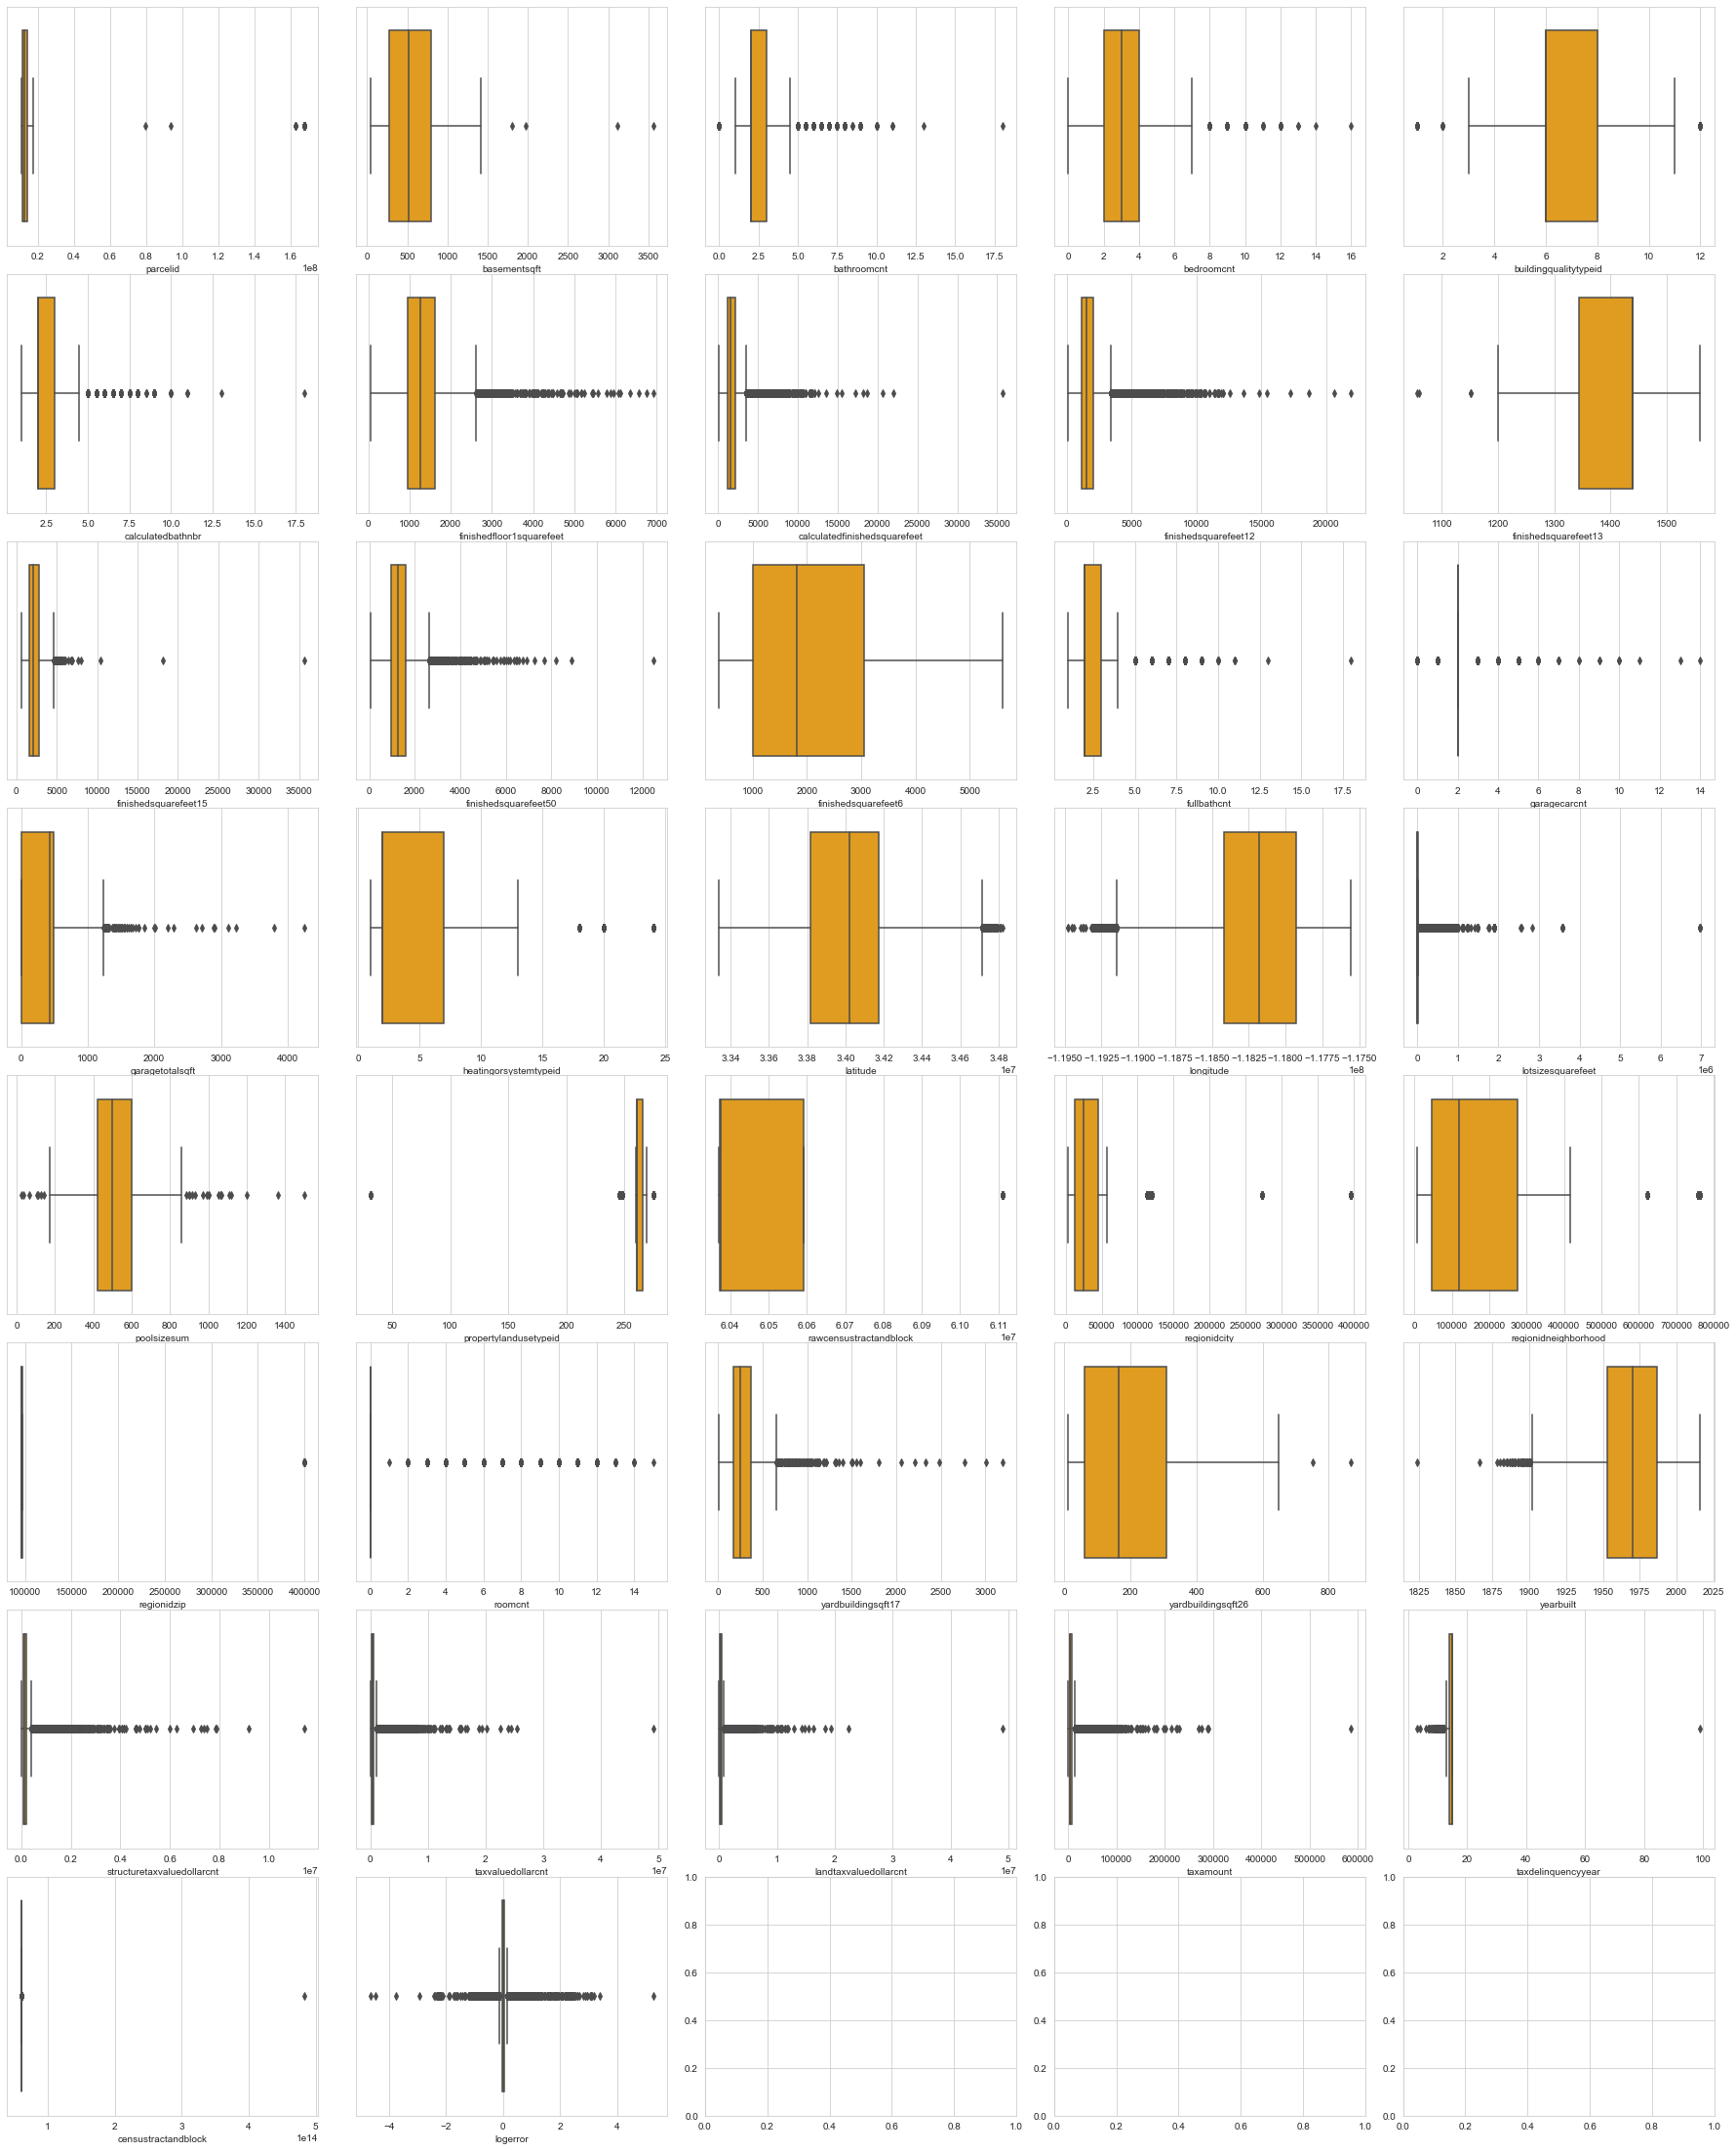

In [147]:
viz.feature_distribution(merged_df,num_vars,subplot_size=(5, 4))

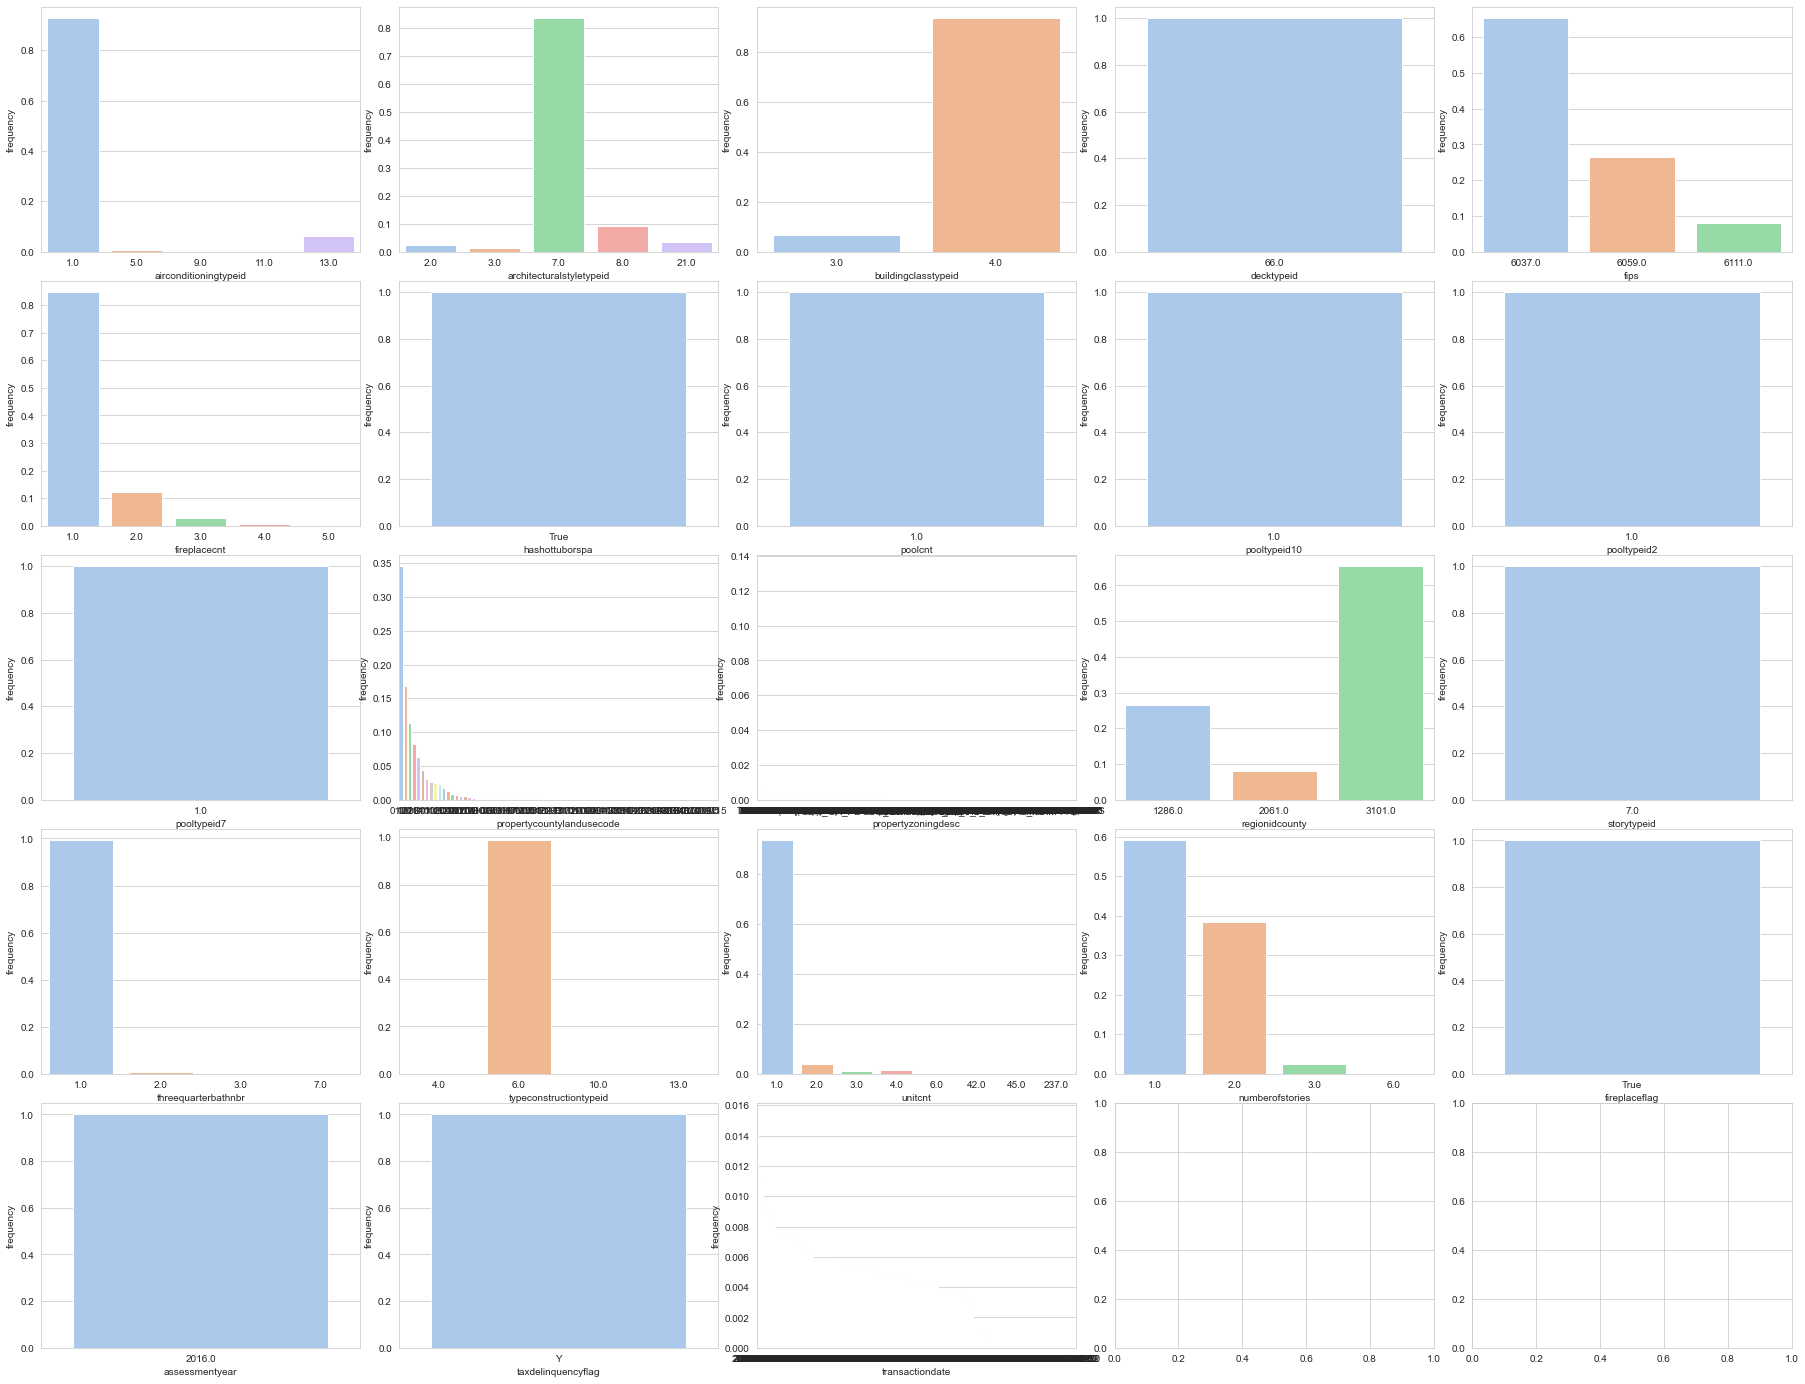

In [148]:
viz.feature_distribution(merged_df,cat_vars,subplot_size=(5, 4),cat = True)

.








.

# Feature Engineering

a.Duplicate value removal

b.Missing value imputation

c.Rescaling of incorrectly scaled data

d.Standardization

e.Encoding of categorical variables

f.Generation of new feature wherever required.

g.Dropping of redundant feature columns

h.Checking for multi-collinearity and removal of highly correlated features

i.Check for the outliners and removal of outliers.

### Correlations

### Store into .csv

Storing this dataframe in a separate .csv will come handy for later tasks.
logerror and transactiondate are dropped because they are not property data.

da [notebook crasto](https://www.kaggle.com/code/devanshm/zillow-end-to-end-ml-workflow-top-250-0-06416/notebook)

## Dropping Outliers

Since the data is mostly normally distributed outside of the outliers, we will drop all values that are more than 2.5 standard deviations away from the mean. For reference, for the standard normal distribution, 68% of the observations lie within 1 standard deviation of the mean; 95% lie within two standard deviation of the mean; and 99.9% lie within 3 standard deviations of the mean.

In [56]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.44397321398406825
Lowest allowed -0.41046332696829874


In [57]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe
housing = merged_df[merged_df.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [58]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(76059, 60)

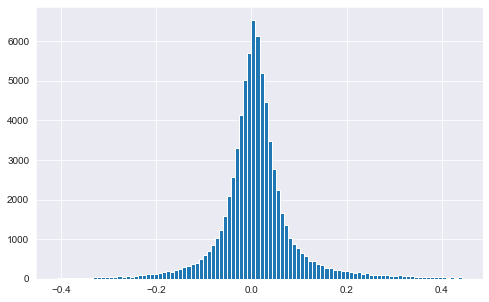

In [59]:
y.hist(bins=100, figsize=(8,5))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.01 and sigma = 0.08



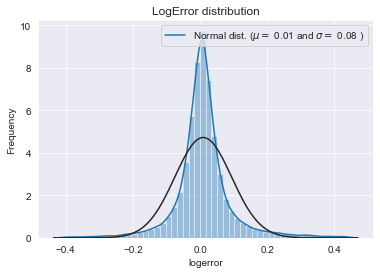

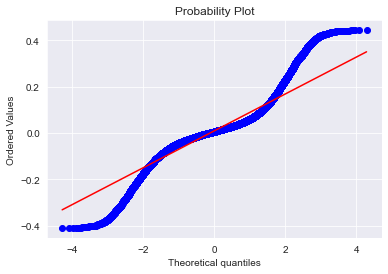

In [60]:
#Check the new distribution
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

The skew seems now corrected and the data appears better normally distributed.

next part is Create Test/Train datasets (per feat eng penso)